<a href="https://colab.research.google.com/github/Xarakt/Training-EKPA/blob/main/IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [2]:

filename = "pcap_data.csv"

df = pd.read_csv(filename)
print("Σχήμα:", df.shape)
print("Στήλες:", df.columns.tolist())


label_column = "target"

y_raw = df[label_column].astype(str).to_numpy()
X_df = df.drop(columns=[label_column])

# Κρατάμε μόνο αριθμητικά χαρακτηριστικά
X_df = X_df.select_dtypes(include=[np.number])
X = X_df.to_numpy().astype("float32")

print("Τελικό σχήμα X:", X.shape)
print("Μοναδικές ετικέτες:", np.unique(y_raw))


Σχήμα: (14967, 26)
Στήλες: ['Avg_syn_flag', 'Avg_urg_flag', 'Avg_fin_flag', 'Avg_ack_flag', 'Avg_psh_flag', 'Avg_rst_flag', 'Avg_DNS_pkt', 'Avg_TCP_pkt', 'Avg_UDP_pkt', 'Avg_ICMP_pkt', 'Duration_window_flow', 'Avg_delta_time', 'Min_delta_time', 'Max_delta_time', 'StDev_delta_time', 'Avg_pkts_lenght', 'Min_pkts_lenght', 'Max_pkts_lenght', 'StDev_pkts_lenght', 'Avg_small_payload_pkt', 'Avg_payload', 'Min_payload', 'Max_payload', 'StDev_payload', 'Avg_DNS_over_TCP', 'target']
Τελικό σχήμα X: (14967, 25)
Μοναδικές ετικέτες: ['0.0' '1.0' '2.0']


In [4]:
# Label encoding
le = LabelEncoder()
y_int = le.fit_transform(y_raw)
nclass = len(np.unique(y_int))

print("Αριθμός κλάσεων:", nclass)
print("Κλάσεις:", le.classes_)

# Min–Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_int, test_size=0.20, random_state=42, stratify=y_int
)

# Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.125, random_state=42,
    stratify=y_train_val
)

# One-hot encoding
y_train_cat = to_categorical(y_train, nclass)
y_val_cat   = to_categorical(y_val,   nclass)
y_test_cat  = to_categorical(y_test,  nclass)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Αριθμός κλάσεων: 3
Κλάσεις: ['0.0' '1.0' '2.0']
Train: (10476, 25)
Val: (1497, 25)
Test: (2994, 25)


In [5]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(nclass, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,779 (46.01 KB)

 Trainable params: 11,779 (46.01 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4334 - loss: 1.0683 - val_accuracy: 0.7448 - val_loss: 0.9296
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6078 - loss: 0.9141 - val_accuracy: 0.7796 - val_loss: 0.7285
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7102 - loss: 0.7431 - val_accuracy: 0.8009 - val_loss: 0.6138
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7625 - loss: 0.6353 - val_accuracy: 0.8069 - val_loss: 0.5662
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7918 - loss: 0.5904 - val_accuracy: 0.8116 - val_loss: 0.5432
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8060 - loss: 0.5601 - val_accuracy: 0.8223 - val_loss: 0.5270
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8192 - loss: 0.5354 - val_accuracy: 0.8390 - val_loss: 0.5001
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8317 - loss: 0.5205 - val_accuracy: 0.8430

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90      1001
         1.0       0.91      0.92      0.91      1003
         2.0       0.91      0.93      0.92       990

    accuracy                           0.91      2994
   macro avg       0.91      0.91      0.91      2994
weighted avg       0.91      0.91      0.91      2994



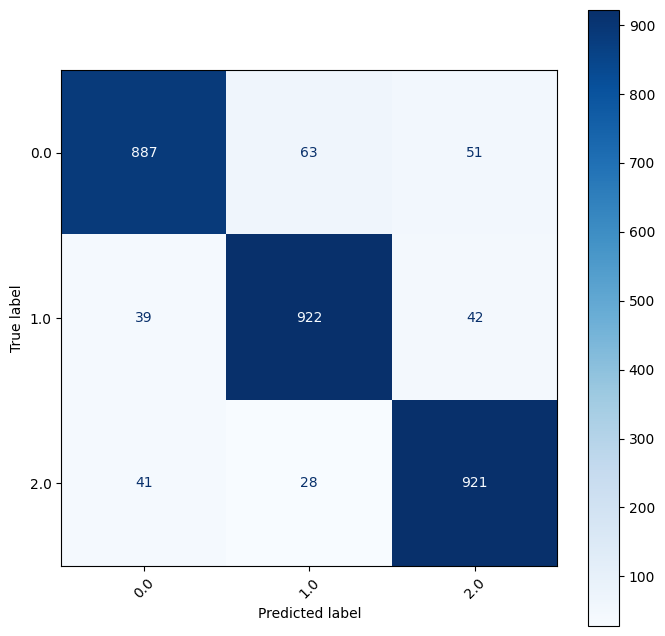

In [7]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')
plt.show()


In [8]:

BENIGN = ["BENIGN", "Normal", "normal"]

def is_malicious(label):
    return label not in BENIGN

def ips_decision(pred_label, pred_prob, high_th=0.90, low_th=0.60):
    """
    BLOCK: υψηλή βεβαιότητα επίθεσης
    ALERT: μέτρια βεβαιότητα
    LOG: χαμηλή βεβαιότητα
    ALLOW: κανονική κίνηση
    """
    if is_malicious(pred_label):
        if pred_prob >= high_th:
            return "BLOCK"
        elif pred_prob >= low_th:
            return "ALERT"
        else:
            return "LOG"
    else:
        return "ALLOW"


In [9]:
pred_labels = le.inverse_transform(y_pred)
max_probs = np.max(y_pred_proba, axis=1)

actions = [ips_decision(lbl, prob) for lbl, prob in zip(pred_labels, max_probs)]

ips_df = pd.DataFrame({
    "pred_label": pred_labels,
    "probability": max_probs,
    "IPS_action": actions
})

ips_df.head(20)


,pred_label,probability,IPS_action
0,1.0,0.956211,BLOCK
1,2.0,0.971400,BLOCK
2,0.0,0.981763,BLOCK
3,1.0,0.976306,BLOCK
4,1.0,0.959686,BLOCK
5,2.0,0.824701,ALERT
6,1.0,0.959874,BLOCK
7,2.0,0.952918,BLOCK
8,2.0,0.899764,ALERT
9,2.0,0.905216,BLOCK


In [10]:
print("Συνολικές ενέργειες IPS:")
print(ips_df["IPS_action"].value_counts())


blocked = ips_df[ips_df["IPS_action"] == "BLOCK"]
alerts  = ips_df[ips_df["IPS_action"] == "ALERT"]

print("\nBLOCKED:", len(blocked))
print("ALERT:", len(alerts))


Συνολικές ενέργειες IPS:
IPS_action
BLOCK    2229
ALERT     678
LOG        87
Name: count, dtype: int64

BLOCKED: 2229
ALERT: 678


In [11]:

blocklist = []

for idx, row in ips_df.iterrows():
    if row["IPS_action"] == "BLOCK":
        blocklist.append(f"Flow {idx} -> BLOCK")


with open("ips_blocklist.txt", "w") as f:
    for entry in blocklist:
        f.write(entry + "\n")

print("Αποθηκεύτηκε blocklist με", len(blocklist), "εγγραφές.")


Αποθηκεύτηκε blocklist με 2229 εγγραφές.
